<a href="https://colab.research.google.com/github/ed765super/DATA602-Baltimore-Employee-Data-Classification/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Background Information/Buisness Question

The Baltimore Police Agency launched a massive overhaul to its new Records Management Systems in May 2020. The improvement will enable the department to migrate from a paper-based system to a completely digital reporting environment. As a consequence of this major shift, we had significant difficulties in appropriately transferring data from the new records system to the previous Open Data Baltimore system. The "Arrests" dataset is one of many open datasets made publicly accessible by Baltimore's police department on the city's Open Data website. This information is provided to us in order to foster more openness and data exchange between the local administration and its residents. This dataset contains arrest records for offenses such as assault, theft, and property damage in the City of Baltimore.

Imma predict the district

Imma use the predicted possibilities to see if there is bias in policing efforts in certain districts.

Note, the goal of this project isnt to get the best accuracy, but your process and your narrative.

In [1]:
import pandas as pd
#https://www.kaggle.com/aashofteh/train-dataset-kaggle-credit-scoring-1
df = pd.read_csv('Arrests.csv', sep=',')
print(df.info())
print(df.describe(include='all'))
df

FileNotFoundError: ignored

#EDA


Before doing anything I need to modify the data types to better represent the values in each of the columns

In [ ]:
dfConverted = df.convert_dtypes()
dfConverted.dtypes

X                    float64
Y                    float64
RowID                  Int64
ArrestNumber           Int64
Age                    Int64
Gender                string
Race                  string
ArrestDateTime        string
ArrestLocation        string
IncidentOffence       string
IncidentLocation      string
Charge                string
ChargeDescription     string
District              string
Post                  string
Neighborhood          string
Latitude             float64
Longitude            float64
GeoLocation           string
Shape                  Int64
dtype: object

First there are some features that will not contribute to my classification problem.
* 'X', 'Y', 'RowID', and 'ArrestNumber': are all similar indexing variables that will provide nothing to the classification
* 'ArrestLocation', 'IncidentLocation', 'Neighborhood': This wouldnt fit my classification problem as my model shouldnt need location information to determine the district the crime happened
* 'Latitude', 'Longitude', and 'GeoLocation' all provide the same information. This wouldnt fit my classification problem as my model shouldnt need location information to determine the district the crime happened
* 'Shape': Shape is a useless feature column that provides no information and is mostly filled with NA values 
* Charge: Charge and Charge Description hold what is basically the same information. Thus when I throw them into a OHE they will provide redundancy which is bad

In [ ]:
dfConverted = dfConverted.drop(['X', 'Y', 'RowID', 'ArrestNumber', 'ArrestLocation', 
              'IncidentLocation', 'Neighborhood', 'Latitude', 'Longitude',
              'GeoLocation', 'Shape', 'Charge'], axis = 1)

In [ ]:
print(dfConverted.dtypes)
dfConverted

Age                   Int64
Gender               string
Race                 string
ArrestDateTime       string
IncidentOffence      string
Charge               string
ChargeDescription    string
District             string
Post                 string
dtype: object


,Age,Gender,Race,ArrestDateTime,IncidentOffence,Charge,ChargeDescription,District,Post
0,27,M,B,2020/12/31 23:50:00+00,96BINVESTIGATIVE STOP,1 0692,HAND GUN VIOLATION,Southwest,813
1,45,F,B,2020/12/31 23:45:00+00,Unknown Offense,2 0480,AUTO THEFT,Western,722
2,42,F,W,2020/12/31 23:40:00+00,Unknown Offense,1 1415,2ND DEGREE ASSAULT,Southwest,832
3,26,M,B,2020/12/31 21:45:00+00,Unknown Offense,1 0233,PWID,Southern,922
4,19,M,B,2020/12/31 21:45:00+00,Unknown Offense,1 0233,PWID,Southern,922
...,...,...,...,...,...,...,...,...,...
175918,35,M,B,2014/01/01 00:05:00+00,Unknown Offense,1 1609,FIREARM VIOLATION,Northeast,432
175919,41,M,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,1 5212,DISCHARGING,Southwest,835
175920,36,F,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,1 5212,DISCHARGING,Southwest,835
175921,30,M,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,1 5212,HGV,Southwest,835


I may want the date and the time seperate to cut down on the sparcity of the dummy matrix formed when one hot encoding. But that is only nessessary if it there are a large number of unique values. So first I will check how many unique values are there vs the total values

In [ ]:
print("There are", dfConverted.ArrestDateTime.count() - len(dfConverted.ArrestDateTime.unique()), "Non unique values")

There are 45088 Non unique values


In [ ]:
#Fromhttps://www.tutorialspoint.com/write-a-program-to-separate-date-and-time-from-the-datetime-column-in-python-pandas
dfConverted['date'] = pd.to_datetime(dfConverted['ArrestDateTime']).dt.date
dfConverted['time'] = pd.to_datetime(dfConverted['ArrestDateTime']).dt.time
dfConverted

,Age,Gender,Race,ArrestDateTime,IncidentOffence,Charge,ChargeDescription,District,Post,date,time
0,27,M,B,2020/12/31 23:50:00+00,96BINVESTIGATIVE STOP,1 0692,HAND GUN VIOLATION,Southwest,813,2020-12-31,23:50:00
1,45,F,B,2020/12/31 23:45:00+00,Unknown Offense,2 0480,AUTO THEFT,Western,722,2020-12-31,23:45:00
2,42,F,W,2020/12/31 23:40:00+00,Unknown Offense,1 1415,2ND DEGREE ASSAULT,Southwest,832,2020-12-31,23:40:00
3,26,M,B,2020/12/31 21:45:00+00,Unknown Offense,1 0233,PWID,Southern,922,2020-12-31,21:45:00
4,19,M,B,2020/12/31 21:45:00+00,Unknown Offense,1 0233,PWID,Southern,922,2020-12-31,21:45:00
...,...,...,...,...,...,...,...,...,...,...,...
175918,35,M,B,2014/01/01 00:05:00+00,Unknown Offense,1 1609,FIREARM VIOLATION,Northeast,432,2014-01-01,00:05:00
175919,41,M,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,1 5212,DISCHARGING,Southwest,835,2014-01-01,00:05:00
175920,36,F,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,1 5212,DISCHARGING,Southwest,835,2014-01-01,00:05:00
175921,30,M,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,1 5212,HGV,Southwest,835,2014-01-01,00:05:00


In [ ]:
dfConverted = dfConverted.drop('ArrestDateTime', axis=1)

In [ ]:
dfConverted

,Age,Gender,Race,IncidentOffence,Charge,ChargeDescription,District,Post,date,time
0,27,M,B,96BINVESTIGATIVE STOP,1 0692,HAND GUN VIOLATION,Southwest,813,2020-12-31,23:50:00
1,45,F,B,Unknown Offense,2 0480,AUTO THEFT,Western,722,2020-12-31,23:45:00
2,42,F,W,Unknown Offense,1 1415,2ND DEGREE ASSAULT,Southwest,832,2020-12-31,23:40:00
3,26,M,B,Unknown Offense,1 0233,PWID,Southern,922,2020-12-31,21:45:00
4,19,M,B,Unknown Offense,1 0233,PWID,Southern,922,2020-12-31,21:45:00
...,...,...,...,...,...,...,...,...,...,...
175918,35,M,B,Unknown Offense,1 1609,FIREARM VIOLATION,Northeast,432,2014-01-01,00:05:00
175919,41,M,B,83DISCHARGING FIREARM,1 5212,DISCHARGING,Southwest,835,2014-01-01,00:05:00
175920,36,F,B,83DISCHARGING FIREARM,1 5212,DISCHARGING,Southwest,835,2014-01-01,00:05:00
175921,30,M,B,83DISCHARGING FIREARM,1 5212,HGV,Southwest,835,2014-01-01,00:05:00


I will start by checking whether any of my features have null values

In [ ]:
print(df.isna().sum())

Age                     87
Gender                  39
Race                    39
ArrestDateTime           0
IncidentOffence          0
Charge               19382
ChargeDescription        0
District             86032
Post                 86032
dtype: int64


#(Change this once we learn about semi supervised learning on 11/16)
Now I will remove all the rows that contain an NA value

This is not smart because you'd skew your accuracy 

In [ ]:
df = df.query('District.notna()', engine='python')
df

Next I will check the 5 number summary for each of my features

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,175836,NaN,NaN,NaN,32.9656,11.421,14,24,30,40,100
Gender,175884,2,M,142091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,175884,5,B,144592,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrestDateTime,175923,130835,2015/04/27 20:00:00+00,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IncidentOffence,175923,172,Unknown Offense,91417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Charge,156541,654,1 1415,32376,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ChargeDescription,175923,7028,FAILURE TO APPEAR,27580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
District,89891,9,Southern,11771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Post,89891,127,114,2504,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next I will gather a visual summary of my data

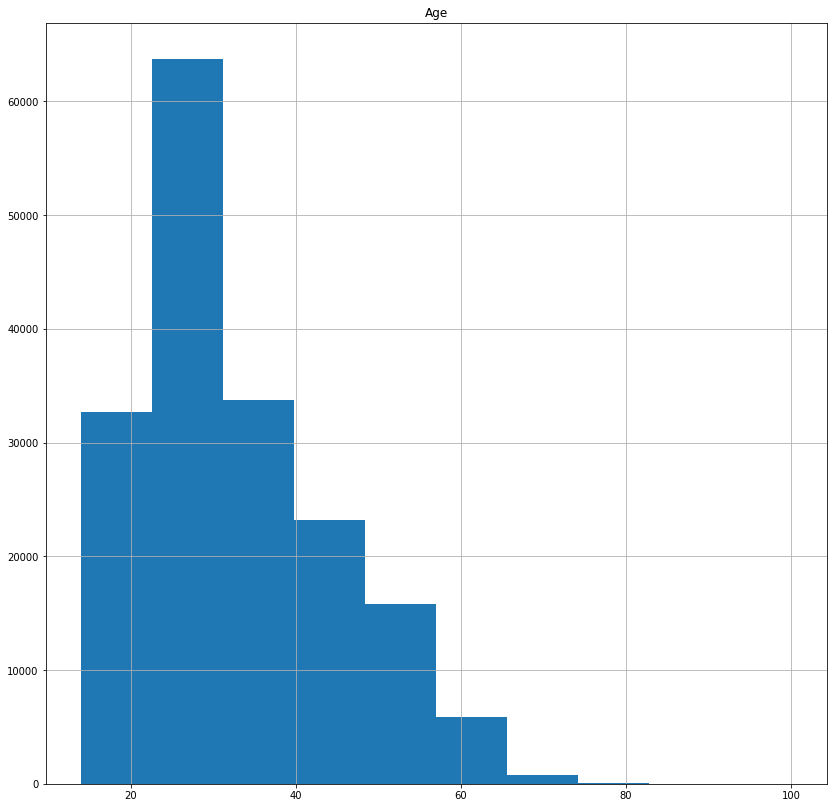

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

feature_names = dfConverted.dtypes[df.dtypes != 'object'].index.tolist()
axes = dfConverted[feature_names].hist(bins=50, figsize=(20,15))
#Learned how to do the for loop for multi graph labeling here: https://stackoverflow.com/questions/69329880/how-do-i-label-the-x-y-axis-of-multiple-graphs-on-a-single-graph/69329975#69329975
plt.show()

Next I'll check for any multicoliniarity

In [ ]:
import seaborn as sns

sns.heatmap(df.corr())
plt.show()

#Data cleaning and Feature engineering


#Modeling


####Splitting Training and Test sets

In [ ]:
from sklearn.model_selection import train_test_split
curr_Random_State = 50

feature_names = df.columns[:-1]
#The :-1 excludes the last column which is the target column.

#Pre:
#X = a valid index list representing columns
#y = a valid column representing the target cass
#state = a positive numeric integer representing the current "random state"
#Post: returns two sets of training-test splits.
def create_splits(x, y, state):
    return (train_test_split(x, y, test_size=.25, random_state = state)
    )
tX_training, tX_test, ty_training, ty_test = create_splits(df[feature_names], df['Class'], curr_Random_State)
print(f'Training samples: {tX_training.shape[0]}')
print(f'Test samples: {tX_test.shape[0]}')

Now I will fit Fit a logistic regression, decision tree, and SVM using grid search

First I will set up the pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
#First grab all the columns and put em in lists
nums = df.dtypes[df.dtypes != 'object'].index.tolist()
cats = df.dtypes[df.dtypes == 'object'].index.tolist()

#Now remove the columns I dont think I need
nums = [x for x in nums if x not in ['arr_delay']]
cats = [x for x in cats if x not in ['tailnum']]

num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])

cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore'))])

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, nums),
                                                      ('create_dummies', cat_pipeline, cats)])

print('Pipeline Created')

Logistic Regression with grid search

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time
start_time = time.time()
p1 = Pipeline([('processing', processing_pipeline),
             ('lr', LogisticRegression(solver='liblinear'))])

#Select various correlation strengths with a magnitude of 10
params = {'lr__C': [.001, 0.01, 0.1, 1, 10, 100]}

#I will score based on accurancy as that the dataset is not heavily skewed
lr_gscv = GridSearchCV(p1, param_grid=params, cv=10, scoring='accuracy', refit=True)

lr_gscv = lr_gscv.fit(tX_train, ty_train)

print(f'Validation score: {lr_gscv.best_score_:.2%}')

lr_pred = lr_gscv.predict(tX_test)

print(f'Test score: {lr_gscv.score(tX_test, ty_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

Validation score: 68.77%
Test score: 67.68%
Runtime:  13.320276260375977  seconds


Descision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time
start_time = time.time()

p2 = Pipeline([('processing', processing_pipeline),
             ('dt', DecisionTreeClassifier())])

params = {'dt__max_depth': [1, 5, 10, 15, 25],
         'dt__min_samples_split': [3, 10, 15]}

dt_gscv = GridSearchCV(p2, param_grid=params, cv=10, scoring='accuracy', refit=True)
dt_gscv = dt_gscv.fit(tX_train, ty_train)

print(f'Validation score: {dt_gscv.best_score_:.2%}')

dt_pred = dt_gscv.predict(tX_test)

print(f'Test score: {dt_gscv.score(tX_test, ty_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

Validation score: 64.59%
Test score: 62.70%
Runtime:  43.282294034957886  seconds


SVM

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time()
svm_m = modeling_pipeline = Pipeline([('processing', processing_pipeline),
                                      ('scaling', StandardScaler(with_mean=False)),
                                       ('model', SVC())])


param_grid = [
  {'model__C': [0.1, 1, 10, 100], 'model__kernel': ['rbf']}
 ]

svm_results = GridSearchCV(estimator=svm_m, param_grid=param_grid, cv=10, scoring='accuracy', refit=True)
svm_results = svm_results.fit(tX_train, ty_train)

print(f'Validation score: {svm_results.best_score_:.2%}')

svm_pred = svm_results.predict(tX_test)

print(f'Test score: {svm_results.score(tX_test, ty_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

Validation score: 64.92%
Test score: 65.09%
Runtime:  195.7040295600891  seconds


#Results and discussion


#Fit an ensemble using the three above models.

In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=1)
clf3 = svm.SVC(probability=True)

pipe1 = Pipeline([('processing', processing_pipeline),
             ('lr', LogisticRegression(solver='liblinear'))])
pipe2 = Pipeline([('processing', processing_pipeline),
             ('dt', DecisionTreeClassifier())])
pipe3 = Pipeline([('processing', processing_pipeline),
                ('scaling', StandardScaler(with_mean=False)),
                ('model', SVC())])

labs = ['Logistic Regression', 'Decision Tree', 'Support Vector Machine']
clfs = [pipe1, pipe2, pipe3]
clfs = zip(labs, clfs)

for lab, clf in clfs:
    scores = cross_val_score(estimator=clf, X=tX_train, y=ty_train, cv=10, scoring='accuracy')
    print(f'Accuracy {scores.mean():.2f} (+/- {scores.std():.2f}) [{lab}]')

Accuracy 0.68 (+/- 0.02) [Logistic Regression]
Accuracy 0.59 (+/- 0.02) [Decision Tree]
Accuracy 0.63 (+/- 0.01) [Support Vector Machine]


In [ ]:
from sklearn.ensemble import VotingClassifier

ems = [('lr', pipe1),('dt', pipe2),('model', pipe3)]
#Changing voting to hard because SVM doesnt use probabilities
#so using the mode is ok
clf4 = VotingClassifier(estimators= ems, weights=None, voting='hard')

scores = cross_val_score(estimator=clf4, X=tX_train, y=ty_train, cv=10, scoring='accuracy')
print(f'Accuracy {scores.mean():.2f} (+/- {scores.std():.2f}) [Ensemble]')

Accuracy 0.66 (+/- 0.01) [Ensemble]


ADA BOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time
start_time = time.time()
# multi-step pipelines don't play as nice with AdaBoost
xt = processing_pipeline.fit_transform(tX_train)

params = {'n_estimators': [50, 100, 200, 500, 1000]
         }

#ABC = AdaBoostClassifier(base_estimator=p2)
ABC = AdaBoostClassifier(DecisionTreeClassifier())


ad_gscv = GridSearchCV(ABC, param_grid = params, cv=10, scoring='accuracy')
           
ad_gscv = ad_gscv.fit(xt, ty_train)

print(f'Validation score: {ad_gscv.best_score_:.2%}')

xtt = processing_pipeline.transform(tX_test)

ad_pred = ad_gscv.predict(xtt)

print(f'Test score: {ad_gscv.score(xtt, ty_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

Validation score: 58.57%
Test score: 58.34%
Runtime:  23.792025566101074  seconds


#Discuss the performance of each model.
* Logistic Regression had the highest accuracy score and took the least amount of time to run
* SVM took the longest despite searching over less correlation strengths. This is most likely due to the immense ammount of copies being created during SVM
* Descision Trees had the lowest accuracy score

#Conclusion/next steps
